In [162]:
# Import library
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [133]:
# Load data
data = pd.read_excel('SMSSpamCollection.xlsx')
# Rename names columns 
data.columns = ['label', 'messages']
data["messages"] = data["messages"].apply(str)

In [134]:
data.describe()

,label,messages
count,5571,5571
unique,2,5168
top,ham,"Sorry, I'll call later"
freq,4824,30


As a first exploratory analisys, we can consider the message lenght:

In [143]:
data["length"] = data["messages"].apply(len)
data.head()
data.sort_values(by='length', ascending=False).head(10)

,label,messages,length
1084,ham,love start attraction feel need every time aro...,442
2433,ham,indian poor india poor country say one swiss b...,413
1578,ham,make girl happy difficult make girl happy need...,391
3016,ham,lt gt fast approaching wish happy new year hap...,384
1862,ham,last thing ever wanted hurt think would laugh ...,361
2848,ham,sad story man last week day wife nt wish paren...,320
2157,ham,sad story man last week day wife nt wish paren...,320
2369,ham,boy loved gal propsd bt didnt mind gv lv lttrs...,319
5103,ham,boy loved gal propsd bt didnt mind gv lv lttrs...,319
3279,ham,solve case man found murdered lt decimal gt lt...,309


As one migth expect from the previous table, 'ham' messages tend to be longer. This can be more thoroughly analized with a histogram:

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

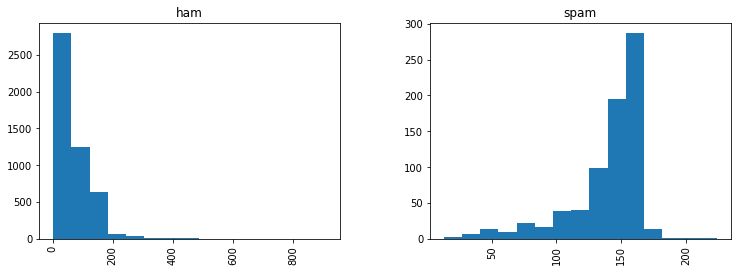

In [34]:
data.hist(column = 'length', by ='label',figsize=(12,4), bins = 15)

For the actual model, the first step should be to remove any stopword and punctuation, this can be achieved with the use of the nltk package. This process is known as tokenization, and can be done with the following function:

In [142]:
# Defining a Function to clean up the messages
def text_preprocess(ds: pd.Series) -> pd.Series:

    for m in range(len(ds)):
        
        main_words = re.sub('[^a-zA-Z]', ' ', ds[m])                                      # Retain only alphabets
        main_words = (main_words.lower()).split()                                         
        main_words = [w for w in main_words if not w in set(stopwords.words('english'))]  # Remove stopwords
        
        lem = WordNetLemmatizer()
        main_words = [lem.lemmatize(w) for w in main_words if len(w) > 1]                 # Stemm words
        
        main_words = ' '.join(main_words)
        ds[m] = main_words

    return ds

data['messages'] = text_preprocess(data['messages'])

C:\Users\carlo\AppData\Local\Temp\ipykernel_7680\1235943380.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds[m] = main_words


For the next step, we assing each token its TF-IDF index, and train our model with a 70-30 split using the resulting feature matrix:

In [168]:
# Spliting into X & y
X = data.iloc[:, 1].values
y = data.iloc[:, 0].values

# Building a TF IDF matrix out of the corpus of messages
td = TfidfVectorizer(max_features = 4500)
X = td.fit_transform(X).toarray()

# Splitting into training & test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Training the classifier & predicting on test data
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

Classification metrics are shown here:

In [169]:
# Classification metrics
cr = classification_report(y_test, y_pred)

print('\n Accuracy: ', accuracy_score(y_test, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', cr)


 Accuracy:  0.9838516746411483

Classification Report

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1432
        spam       0.99      0.90      0.94       240

    accuracy                           0.98      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.98      0.98      0.98      1672



And the confusion matrix:

In [170]:
# Confusion matrix
print('Confusion matrix')
print('\n', confusion_matrix(y_test,y_pred))

Confusion matrix

 [[1430    2]
 [  25  215]]
